# **Measuring Bias in classification**


This notebook is a tutorial on auditing bias within a binary classification task. We will use the holisticai library both in the **data exploration** and **measure bias** sections, introducing some of the functions we have created to help study algorithmic bias.

The sections are organised as follows :
1. Load the data : we load the law school dataset as a pandas DataFrame
2. Data Exploration : some preliminary analysis of the data
3. Train a Model : we train a simple logistic regression model (sklearn)
4. Measure Bias : we compute a few bias metrics, and comment on their meaning

## **Load the data**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [3]:
!pip show holisticai

Name: holisticai
Version: 0.7.4
Summary: Holistic AI Library
Home-page: 
Author: Research Team
Author-email: 
License: 
Location: /Users/zekunwu/Desktop/metrics-and-mitigations/venv/lib/python3.9/site-packages
Requires: scikit-learn
Required-by: 


In [4]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

/var/folders/64/lfz3kc9x5x9cv5dk8bm5j0gm0000gn/T/ipykernel_22803/2956278181.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We host a few example datasets on the holisticai library for quick loading and experimentation. Here we load and use the Law School dataset. The goal of this dataset is the prediction of the binary attribute 'bar' (whether a student passes the law school bar). The protected attributes are race and gender. We pay special attention to race in this case, because preliminary exploration hints there is strong inequality on that sensitive attribute.

In [8]:
from holisticai.holisticai.robustness import load_dataset
df, group_a, group_b = load_dataset(dataset='law_school', preprocessed=True, as_array=False)
df

,age,decile1,decile3,fam_inc,lsat,ugpa,cluster,fulltime,target
0,62.0,10.0,10.0,5.0,44.0,3.5,1.0,1.0,1.0
1,62.0,5.0,4.0,4.0,29.0,3.5,2.0,1.0,1.0
2,61.0,8.0,7.0,3.0,37.0,3.4,1.0,1.0,1.0
3,60.0,8.0,7.0,4.0,43.0,3.3,1.0,1.0,1.0
4,57.0,3.0,2.0,4.0,41.0,3.3,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
20795,60.0,9.0,8.0,4.0,42.0,3.0,5.0,1.0,1.0
20796,61.0,4.0,9.0,4.0,29.5,3.5,3.0,1.0,1.0
20797,62.0,1.0,1.0,3.0,33.0,3.1,3.0,1.0,0.0
20798,65.0,4.0,5.0,3.0,32.0,3.0,3.0,2.0,1.0


In [5]:
from holisticai.datasets import load_dataset
df, group_a, group_b = load_dataset(dataset='law_school', preprocessed=True, as_array=False)
df

ModuleNotFoundError: No module named 'holisticai.datasets'

## **Data Exploration**

We import some of the holisticai plotters for quick exploration of the data.

In [3]:
from holisticai.bias.plots import group_pie_plot, frequency_plot

ModuleNotFoundError: No module named 'holisticai.bias'

In [4]:
y = df['target']        # binary label vector

NameError: name 'df' is not defined

In [5]:
group_pie_plot(group_a)

NameError: name 'group_pie_plot' is not defined

The proportion of white people in law school is very high, allready we observe there is a big representation issue.

In [6]:
frequency_plot(group_a, y)

NameError: name 'frequency_plot' is not defined

We also observe that the white group has a much higher pass rate (within the dataset) than the non-white group.

## **Train a model**


Here we train a Logistic Regression classifier.

In [7]:
from sklearn.model_selection import train_test_split

# split features and target, then train test split
X = df.drop(columns=['target'])


X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.3, random_state=42)

NameError: name 'df' is not defined

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# train a model, do not forget to standard scale data
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train)
LR = LogisticRegression(random_state=42, max_iter=500)
LR.fit(X_train_t, y_train)
X_test_t = scaler.transform(X_test)
y_pred = LR.predict(X_test_t)

In [16]:
from holisticai.efficacy.metrics import classification_efficacy_metrics

classification_efficacy_metrics(y_pred, y_test)

,Value,Reference
Metric,,
Accuracy,0.902724,1
Balanced Accuracy,0.775417,1
Precision,0.984372,1
Recall,0.913333,1
F1-Score,0.947523,1


## **Measure bias**

The holisticai.bias.metrics module contains a range of metrics useful in evaluating the fairness of algorithmic decisions. In this case we use only a few of the metrics relevant to a classification task.

In [11]:
# import some bias metrics
from holisticai.bias.metrics import statistical_parity
from holisticai.bias.metrics import disparate_impact
from holisticai.bias.metrics import accuracy_diff

In [12]:
# set up groups, prediction array and true (aka target/label) array.
y_pred  = LR.predict(X_test_t)          # prediction vector
y_true  = y_test                        # true vector

<Axes: xlabel='Group', ylabel='Frequency'>

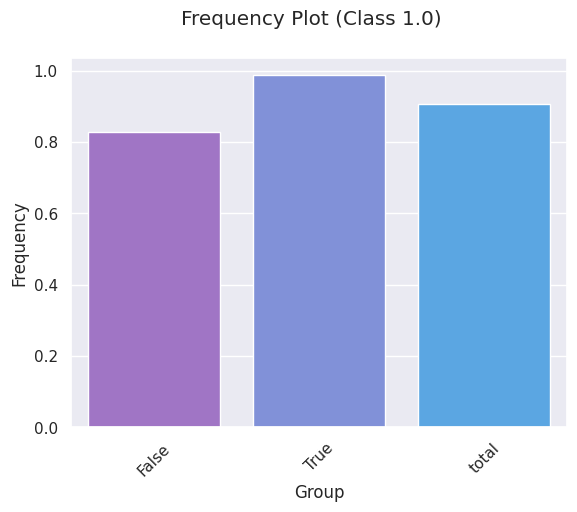

In [17]:
frequency_plot(group_a_ts, y_pred)

In [19]:
# compute statistical parity
statistical_parity(group_a_ts, group_b_ts, y_pred)

0.1583838383838384

The statistical parity indicates the difference in success rate between non-white and white groups. In this case it is outside of ranges considered fair (-0.1, 0.1).

In [20]:
# compute disparate impact
disparate_impact(group_a_ts, group_b_ts, y_pred)

1.191219512195122

The disparate impact on the other hand is within the fair range (0.8, 1.2). This shows the importance of considering many different metrics to get a holistic picture of the situation.

In [21]:
# compute accuracy difference
accuracy_diff(group_a_ts, group_b_ts, y_pred, y_true)

0.12809812409812404

The above metric is different from the first two in that it also uses the target values, this is an equality of opportunity metric. A value of -0.12 shows that the classifier we trained is less accurate on non-white group than white group. This is expected because of the data imbalance.

<Axes: xlabel='Group', ylabel='Accuracy'>

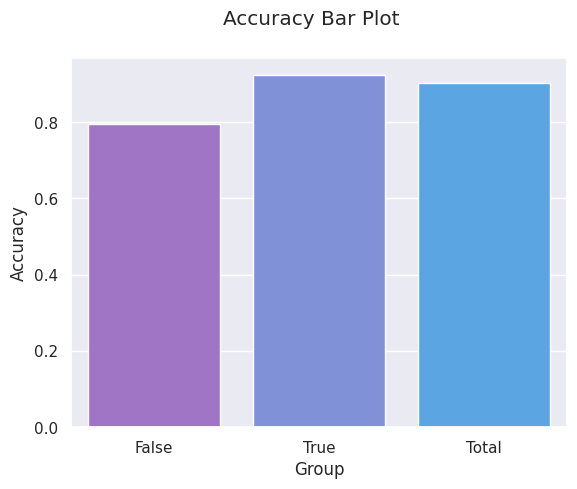

In [22]:
from holisticai.bias.plots import accuracy_bar_plot

accuracy_bar_plot(group_a_ts, y_pred, y_true)

The above shows the same result as accuracy_diff metric in plot form.

**Equality of outcome metrics (batch computation)**

In [23]:
# import function for batch computation
from holisticai.bias.metrics import classification_bias_metrics

In [24]:
classification_bias_metrics(group_a_ts, group_b_ts, y_pred, y_true, metric_type='equal_outcome')

,Value,Reference
Metric,,
Statistical Parity,0.158384,0
Disparate Impact,1.191220,1
Four Fifths Rule,0.839476,1
Cohen D,0.863802,0
2SD Rule,23.769452,0


**Equality of opportunity metrics (batch computation)**

In [26]:
classification_bias_metrics(group_a_ts, group_b_ts, y_pred, y_true, metric_type='equal_opportunity')

,Value,Reference
Metric,,
Equality of Opportunity Difference,0.069042,0
False Positive Rate Difference,0.344579,0
Average Odds Difference,0.206811,0
Accuracy Difference,0.128098,0


For instance the false positive rate difference of 0.34 hints that white people are more likely to be missclassified as passing the bar than non-whites.

We can show all group bias metrics by setting 'metric_types' as 'group':

In [27]:
classification_bias_metrics(group_a=group_a_ts, group_b=group_b_ts, y_pred=y_pred, y_true=y_true, metric_type='group')

,Value,Reference
Metric,,
Statistical Parity,0.158384,0
Disparate Impact,1.191220,1
Four Fifths Rule,0.839476,1
Cohen D,0.863802,0
2SD Rule,23.769452,0
Equality of Opportunity Difference,0.069042,0
False Positive Rate Difference,0.344579,0
Average Odds Difference,0.206811,0
Accuracy Difference,0.128098,0


We can show all individual bias metrics by setting 'metric_types' as 'individual'.

In [28]:
classification_bias_metrics(y_pred=y_pred, y_true=y_true, X=X_test_t, metric_type='individual')

,Value,Reference
Metric,,
Theil Index,0.040939,0
Generalized Entropy Index,0.040425,0
Coefficient of Variation,0.402121,0
Consistency Score,0.979551,1


You can pass specific parameters for individual fairness metrics:

In [29]:
individual_kargs = {
    'generalized_entropy_index__alpha': 2,
    'consistency_score__n_neighbors' : 5
}
classification_bias_metrics(y_pred=y_pred, y_true=y_true, X=X_test_t, metric_type='individual', **individual_kargs)

,Value,Reference
Metric,,
Theil Index,0.040939,0
Generalized Entropy Index,0.040425,0
Coefficient of Variation,0.402121,0
Consistency Score,0.979551,1
